In [6]:
# These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")

# Importing GemPy
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt

import theano
import theano.tensor as T
import pymc3 as pm
theano.config.optimizer_including

from io import StringIO
import sys


In [7]:
path_to_data = os.pardir+"/../data/input_data/jan_models/"

geo_data = gp.create_data([0,1000,0,1000,0,1000],resolution=[10,1,10], 
                        path_o = path_to_data + "model1_orientations.csv",
                        path_i = path_to_data + "model1_surface_points.csv") 

Active grids: ['regular']


In [3]:
geo_data.surfaces

,surface,series,order_surfaces,isBasement,color,id
0,rock2,Default series,1,False,#015482,1
1,rock1,Default series,2,False,#9f0052,2
2,basement,Basement,1,True,#ffbe00,3


In [16]:
geo_data.delete_surfaces('rock1',remove_data=True)

,surface,series,order_surfaces,isBasement,color,id
0,rock2,Default series,1,False,#015482,1
2,basement,Basement,1,True,#ffbe00,2


In [17]:
geo_data.surface_points

,X,Y,Z,X_r,Y_r,Z_r,surface,series,id,order_series,smooth
0,400,500,599,0.4376,0.5001,0.561975,rock2,Default series,1,1,1.000000e-08
1,500,200,600,0.5001,0.3126,0.562600,rock2,Default series,1,1,1.000000e-08
2,900,200,600,0.7501,0.3126,0.562600,rock2,Default series,1,1,1.000000e-08
3,100,800,600,0.2501,0.6876,0.562600,rock2,Default series,1,1,1.000000e-08
4,500,800,600,0.5001,0.6876,0.562600,rock2,Default series,1,1,1.000000e-08
5,900,800,600,0.7501,0.6876,0.562600,rock2,Default series,1,1,1.000000e-08


In [18]:
geo_data.delete_surface_points([2,3,4,5])

,X,Y,Z,X_r,Y_r,Z_r,surface,series,id,order_series,smooth
0,400,500,599,0.4376,0.5001,0.561975,rock2,Default series,1,1,1.000000e-08
1,500,200,600,0.5001,0.3126,0.562600,rock2,Default series,1,1,1.000000e-08


In [19]:
geo_data.modify_surface_points([0,1], Y=500, X=500.001)

,X,Y,Z,X_r,Y_r,Z_r,surface,series,id,order_series,smooth
0,500.001,500.0,599,0.50035,0.5001,0.2501,rock2,Default series,1,1,1.000000e-08
1,500.001,500.0,600,0.50035,0.5001,0.7501,rock2,Default series,1,1,1.000000e-08


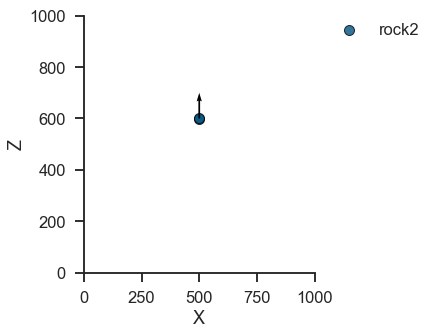

In [20]:
gp.plot.plot_data(geo_data)

In [10]:
gp.set_interpolation_data(geo_data, theano_optimizer='fast_compile',
                         verbose=['n_surface_op_float_sigmoid', 'compare'])

Compiling theano function...
Compilation Done!


In [148]:
# Cleaning buffer
old_stdout = sys.stdout
mystdout = sys.stdout = StringIO()

# Computing model
gp.compute_model(geo_data)

# Black magic update
sys.stdout = old_stdout

# Split print strings
output = mystdout.getvalue().split('\n')

# Init parameters
n_surface_op_float_sigmoid = []
n_surface_0 = []
n_surface_1 = []
a = []
b = []
drift = []

for s in output:
    if 'n_surface_op_float_sigmoid __str__' in s:
        n_surface_op_float_sigmoid.append(np.fromstring(s[s.find('[[')+2:-2], dtype='float', sep=' '))
    if 'n_surface_0 __str__' in s:
        n_surface_0.append(np.fromstring(s[s.find('[[')+2:-2], dtype='float', sep=' '))
    if 'n_surface_1 __str__' in s:
        n_surface_1.append(np.fromstring(s[s.find('[[')+2:-2], dtype='float', sep=' '))
    if 'a __str__' in s:
        a.append(float(s[s.find('= ')+2:]))
    if 'b __str__' in s:
        b.append(float(s[s.find('= ')+2:]))
    if 'drift[slice_init:slice_init+1][0] __str__' in s:
        drift.append(np.fromstring(s[s.find('[[')+2:-2], dtype='float', sep=' '))


a, b, n_surface_0, n_surface_1, drift

../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))


([2.4033346296760425, -1.5857528521496411],
 [-1.5857528521496411, -3.724038768183826],
 [array([1.]), array([2.])],
 [array([1.]), array([-1.])],
 [array([1.]), array([2.])])

In [54]:
geo_data.solutions.scalar_field_matrix.max(), geo_data.solutions.scalar_field_matrix.min()

(350001.00020827644, -549998.9998130058)

In [55]:
geo_data.solutions.scalar_field_at_surface_points

array([[1.0002]])

In [56]:
def plot_sig(n_surface_0 , n_surface_1 , a , b, drift ,
             l = 50, Z_x = None, sf_max=None, sf_min=None, sf_at_scalar=None):
    if Z_x is None:
        Z_x = np.linspace(-3, 3, 2000)
    f_x_s = np.zeros_like(Z_x)
    
    if len(n_surface_0) == 1:

        f_x = -n_surface_0 / (1 + np.exp(-l * (Z_x - a))) - \
                       (n_surface_1 / (1 + np.exp(l * (Z_x - b)))) + drift
        plt.plot(f_x, Z_x)
    
    
    else:
        len_ = len(n_surface_0)
        fig = plt.figure(figsize=(7, 12))
        for e in range(len_):
            f_x = - n_surface_0[e] / (1 + np.exp(-l * (Z_x - a[e]))) - \
                    (n_surface_1[e] / (1 + np.exp(l * (Z_x - b[e])))) + drift[e]
            f_x_s += f_x
            #fig.add_subplot(len_, 1, e+1)
            plt.plot(f_x, Z_x, '--', label='Layer '+str(drift[e]))
        if sf_max is not None:
            plt.hlines(sf_max, 0, f_x_s.max(), label='Model Extent')
        if sf_min is not None:
            plt.hlines(sf_min, 0, f_x_s.max())
        if sf_at_scalar is not None:
            plt.hlines(sf_at_scalar, 0, f_x_s.max(), linewidth=3,
                       color=['#015482', '#9f0052'], label='Scalar value interfaces')
        
        plt.plot(f_x_s, Z_x, linewidth=5, alpha=.7, label='Actual exporty')
        plt.ylabel('Scalar field')
        plt.xlabel('Lith block')
      #  plt.gca().invert_yaxis()

        plt.legend(bbox_to_anchor=(1.8,1))

In [ ]:
gp.core.data.Colors.colo

<IPython.core.display.Javascript object>


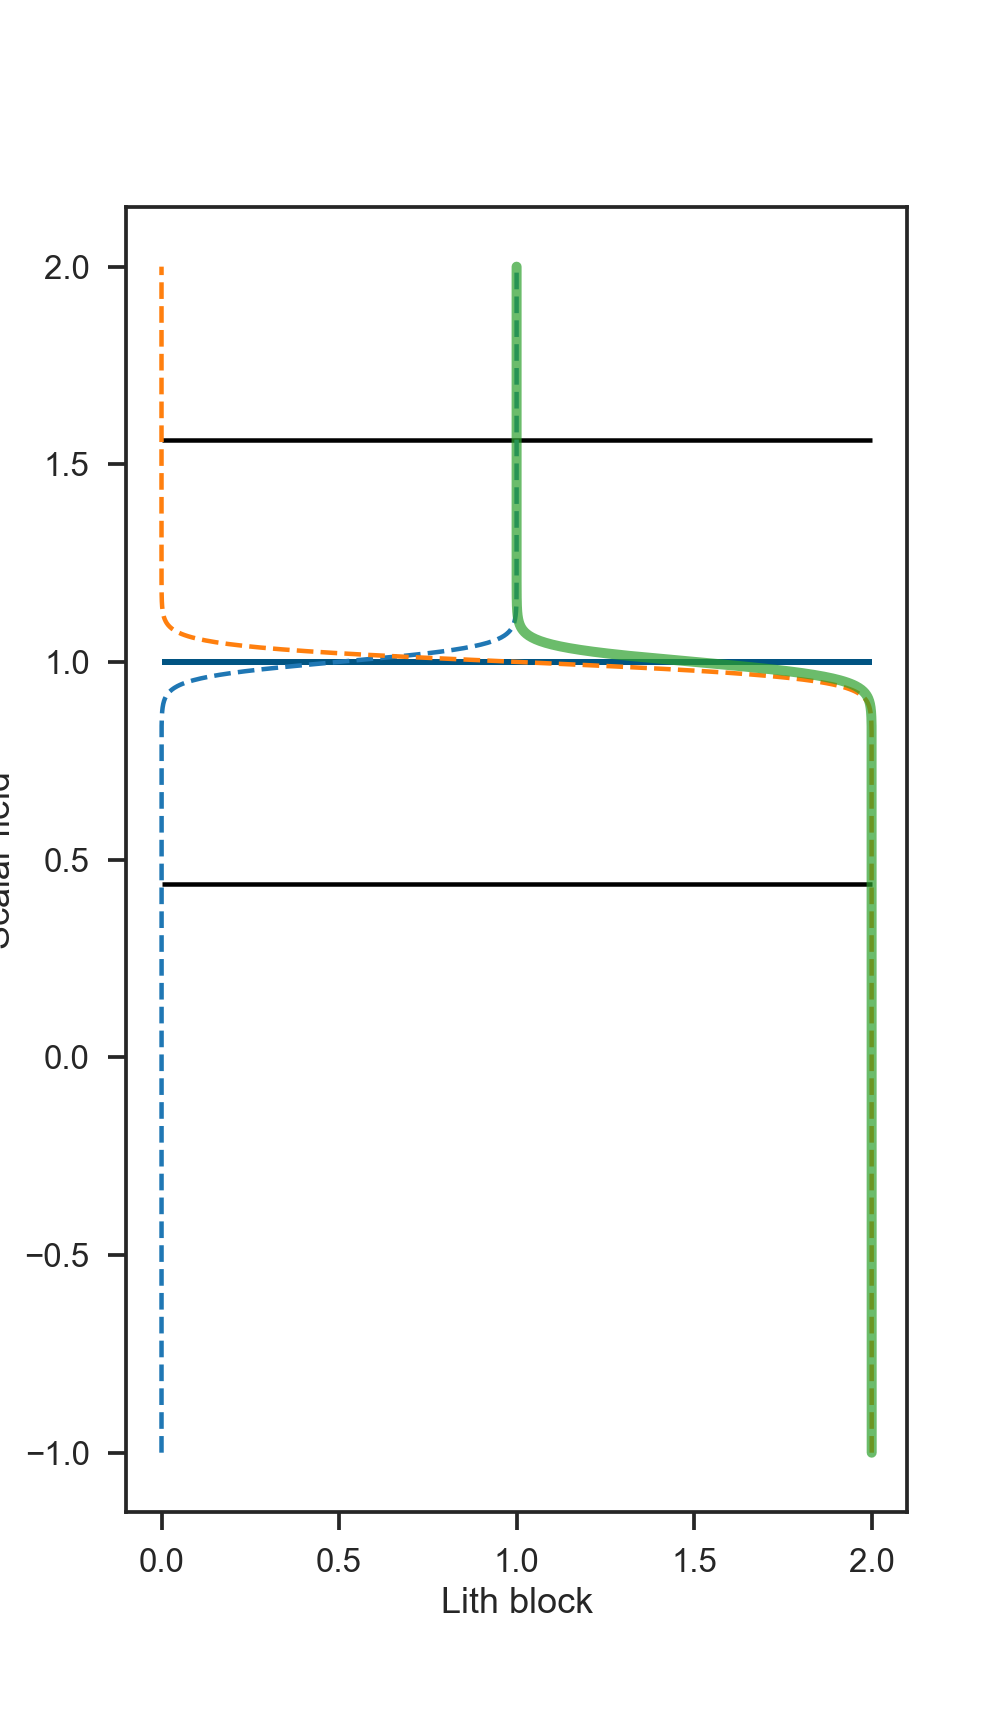

In [57]:
plot_sig(n_surface_0[:], n_surface_1, a, b, drift, Z_x = np.linspace(-1,2,2000),
         sf_max=1.5627, sf_min=0.4377, sf_at_scalar=geo_data.solutions.scalar_field_at_surface_points[0])

#### Lith block

<IPython.core.display.Javascript object>


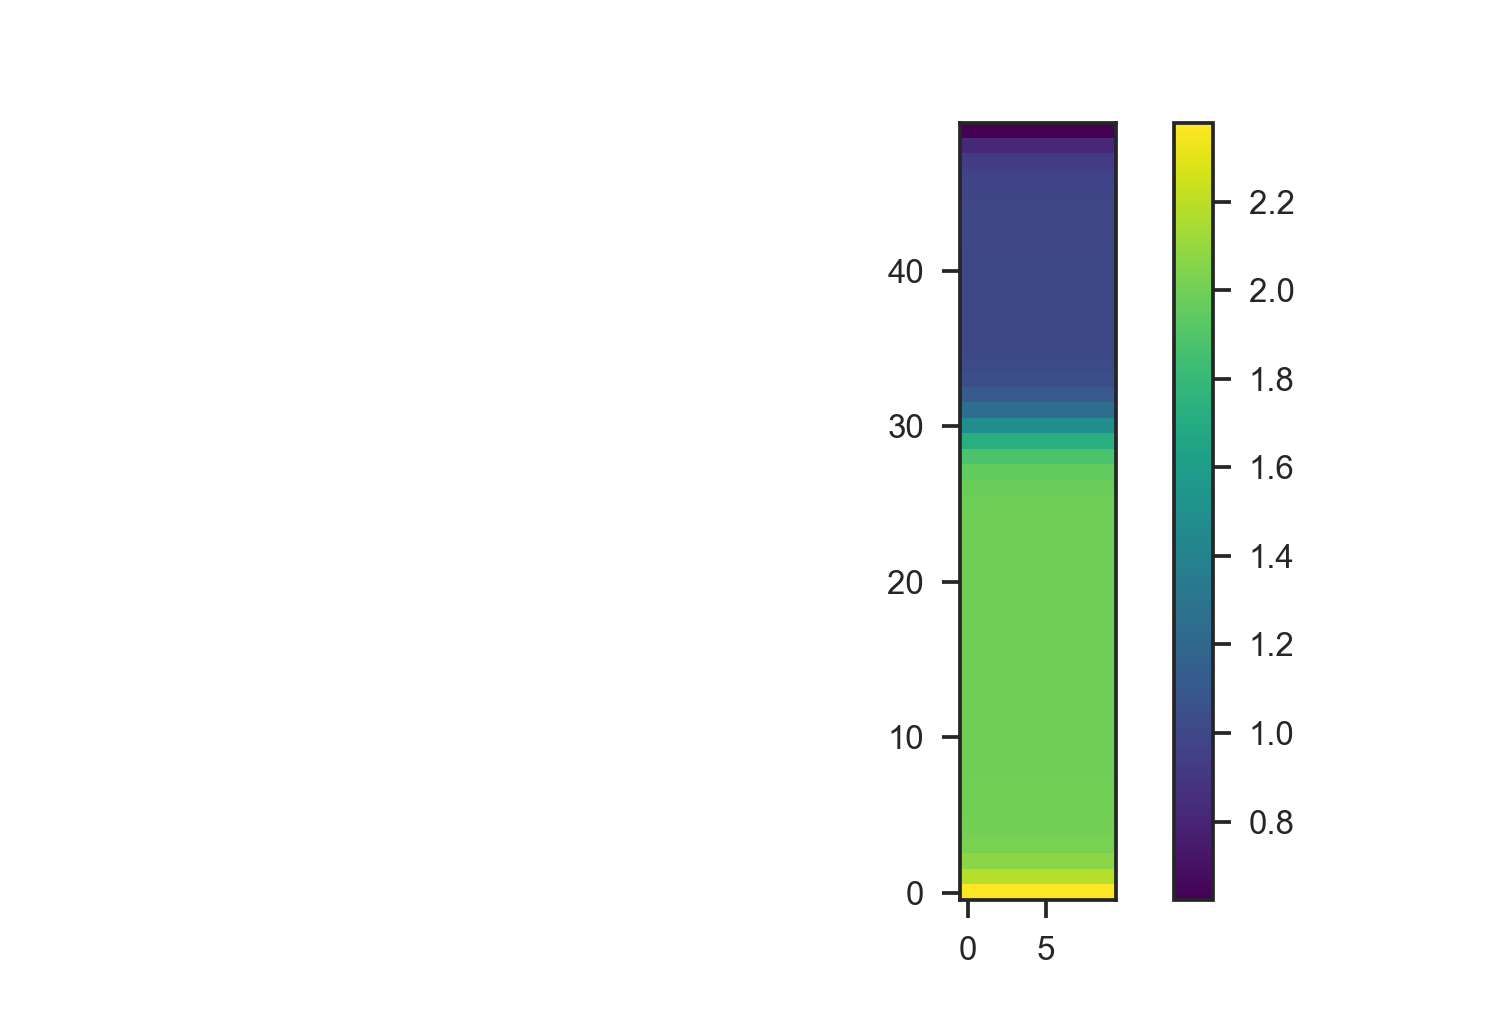

In [58]:
%matplotlib notebook
plt.imshow(geo_data.solutions.lith_block.reshape(geo_data.grid.regular_grid.resolution)[:, 0,:].T,
          origin='bottom', cmap='viridis')
plt.colorbar()

<IPython.core.display.Javascript object>


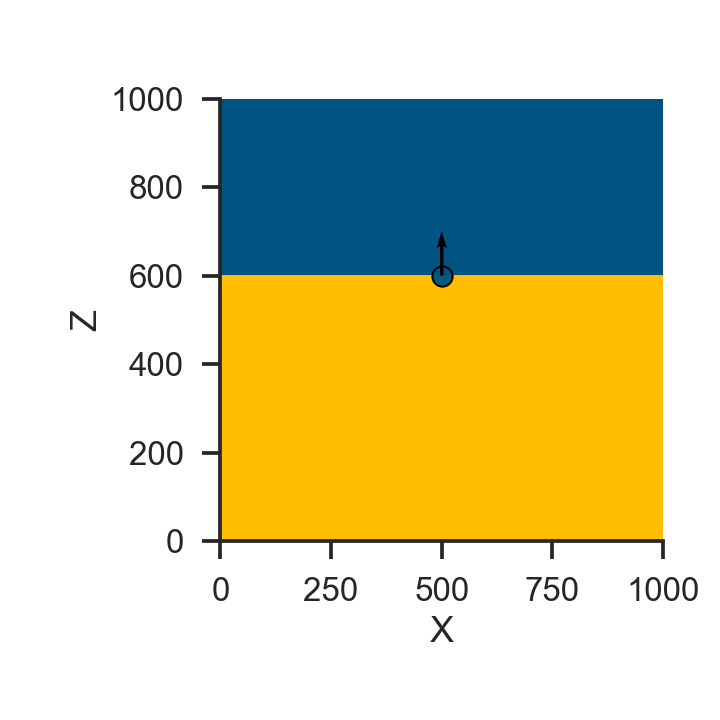

In [59]:
gp.plot.plot_section(geo_data, 0, show_data=True)

<IPython.core.display.Javascript object>


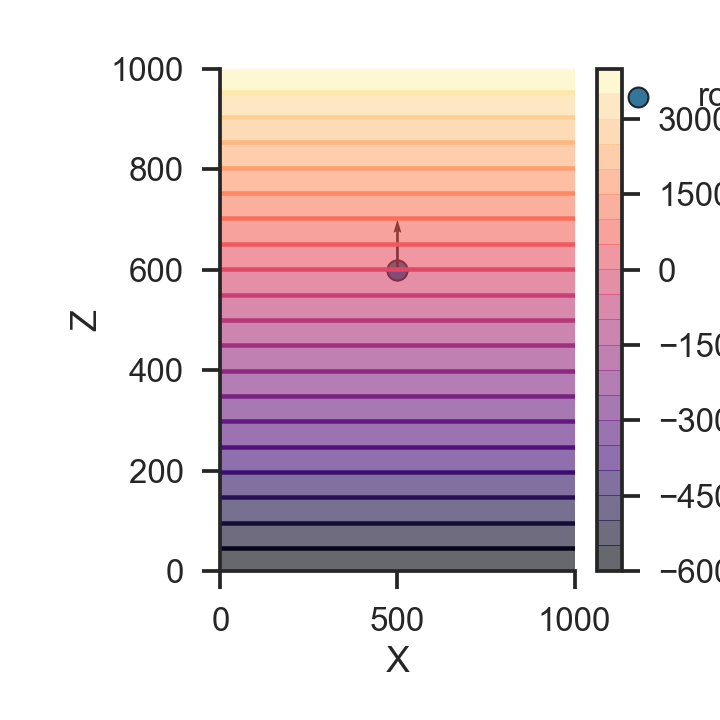

In [33]:
gp.plot.plot_scalar_field(geo_data, 0)
plt.colorbar()

### Calculating the value in a similar way to ensure comparison

In [60]:
th_f = theano.function(geo_data.interpolator.theano_graph.input_parameters_loop,
                      (geo_data.interpolator.theano_graph.compute_series()[0][-1]*1),
                          # mode=NanGuardMode(nan_is_error=True),
                         on_unused_input='ignore')

In [61]:
s = th_f(*geo_data.interpolator.get_python_input_block())

In [62]:
s.shape

(502,)

<IPython.core.display.Javascript object>


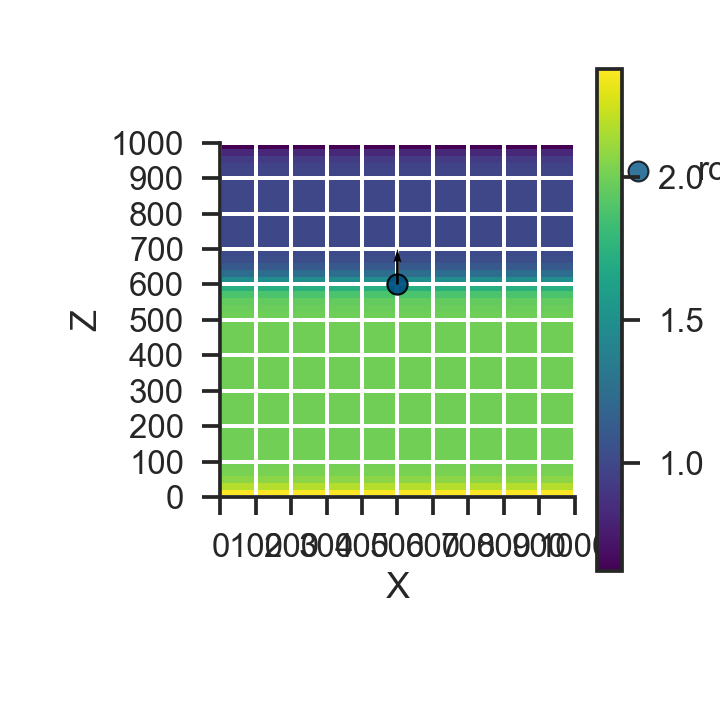

In [64]:
gp.plot.plot_data(geo_data)
plt.imshow(s[:500].reshape(geo_data.grid.regular_grid.resolution)[:, 0,:].T,
          origin='bottom', cmap='viridis', extent=(0,1000,0,1000))

ax = plt.gca();
ax.set_xticks(np.linspace(-0, 1000, 11));
ax.set_yticks(np.linspace(-0, 1000, 11));
ax.grid(color='w', linestyle='-', linewidth=2)

plt.colorbar()
# The row below the blue dot is 1.94

### Calculating the gradient

In [65]:
respect = geo_data.interpolator.theano_graph.input_parameters_loop[4]
th_f_g = theano.function(geo_data.interpolator.theano_graph.input_parameters_loop,
                         T.grad((geo_data.interpolator.theano_graph.compute_series()[0][-1]*1).sum(), 
                                respect),
                          # mode=NanGuardMode(nan_is_error=True),
                         on_unused_input='ignore')
print("Respect: " + str(respect))


In [66]:
geo_data.interpolator.get_python_input_block()[4]

array([[0.7501, 0.5001, 0.5001],
       [0.7501, 0.5001, 0.5001]])

In [67]:
th_f_g(*geo_data.interpolator.get_python_input_block())

array([[ 0.00000000e+00,  0.00000000e+00, -2.77777780e-05],
       [ 0.00000000e+00,  0.00000000e+00,  1.11666698e-03]])

### Calculating the jacobian

In [130]:
respect = geo_data.interpolator.theano_graph.input_parameters_loop[4]
th_f_j = theano.function(geo_data.interpolator.theano_graph.input_parameters_loop,
                         T.jacobian((geo_data.interpolator.theano_graph.compute_series()[0][-1]), 
                                respect),
                          # mode=NanGuardMode(nan_is_error=True),
                         on_unused_input='ignore')
print("Respect: " + str(respect))

/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/gof/cc.py:968: UserWarning: Your g++ compiler fails to compile OpenMP code. We know this happen with some version of the EPD mingw compiler and LLVM compiler on Mac OS X. We disable openmp everywhere in Theano. To remove this warning set the theano flags `openmp` to False.
  ret += x.c_compile_args()


Respect: All the surface_points points at once


In [69]:
jac = th_f_j(*geo_data.interpolator.get_python_input_block())

In [71]:
jac.shape

(502, 2, 3)

In [72]:
jac[:500, 1, 2]

array([5.96552021e-18, 1.65503033e-17, 4.59159517e-17, 1.27385860e-16,
       3.53410021e-16, 9.80474932e-16, 2.72015799e-15, 7.54660751e-15,
       2.09367563e-14, 5.80854064e-14, 1.61147906e-13, 4.47076969e-13,
       1.24033765e-12, 3.44110198e-12, 9.54674079e-12, 2.64857718e-11,
       7.34801274e-11, 2.03857416e-10, 5.65563434e-10, 1.56902951e-09,
       4.35278267e-09, 1.20743634e-08, 3.34853158e-08, 9.27999114e-08,
       2.56695289e-07, 7.06340488e-07, 1.91587398e-06, 4.99906098e-06,
       1.18075235e-05, 2.22093470e-05, 2.77554725e-05, 2.10568213e-05,
       1.08204854e-05, 4.50875112e-06, 1.71697022e-06, 6.31495462e-07,
       2.29294573e-07, 8.28677699e-08, 2.98980407e-08, 1.07803938e-08,
       3.88625143e-09, 1.40085341e-09, 5.04942655e-10, 1.82006521e-10,
       6.56039856e-11, 2.36468294e-11, 8.52344969e-12, 3.07225889e-12,
       1.10738896e-12, 3.99155908e-13, 5.96552021e-18, 1.65503033e-17,
       4.59159517e-17, 1.27385860e-16, 3.53410021e-16, 9.80474932e-16,
      

<IPython.core.display.Javascript object>


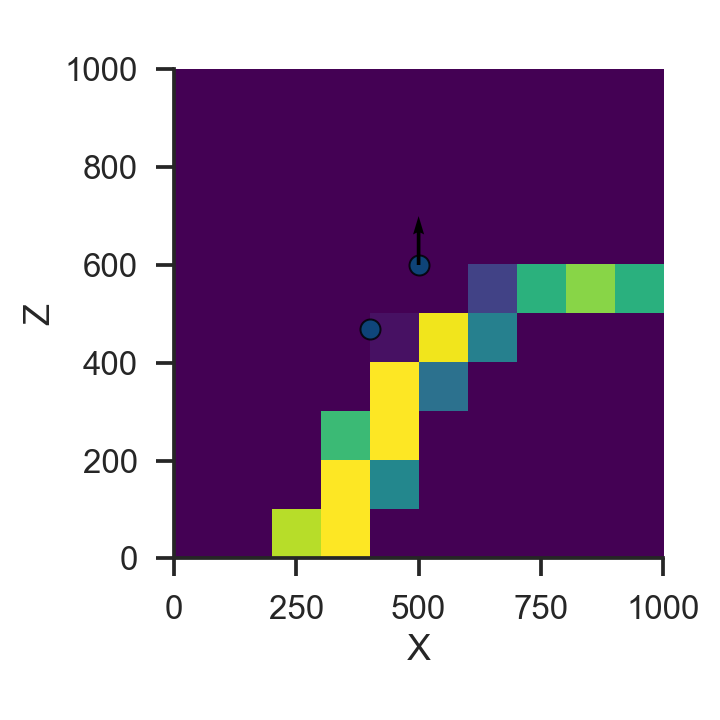

In [157]:
point = 0

gp.plot.plot_section(geo_data, 0,
                     block=jac[:100, point, 2].reshape(geo_data.grid.regular_grid.resolution), show_data=True,
                     cmap='viridis')

<IPython.core.display.Javascript object>


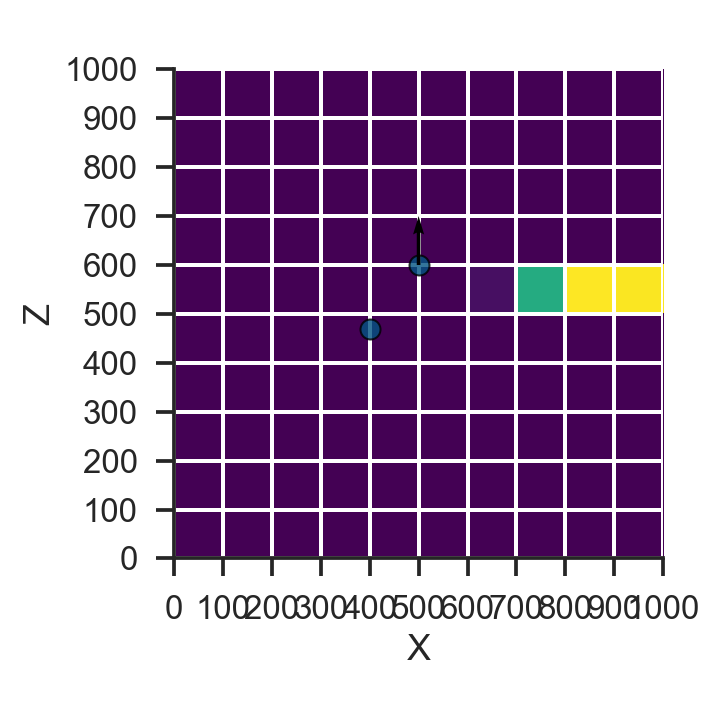

In [158]:
point = 1

gp.plot.plot_section(geo_data, 0,
                     block=jac[:100, point, 2].reshape(geo_data.grid.regular_grid.resolution), show_data=True,
                     cmap='viridis', show_grid=True)
# ax = plt.gca();
# ax.set_xticks(np.linspace(-0, 1000, 11));
# ax.set_yticks(np.linspace(-0, 1000, 11));
# ax.grid(color='w', linestyle='-', linewidth=2)

### How changing values change the jacobian:

In [75]:
geo_data.surface_points

,X,Y,Z,X_r,Y_r,Z_r,surface,series,id,order_series,smooth
0,500.001,500.0,600,0.7501,0.5001,0.5001,rock2,Default series,1,1,1.000000e-08
1,500.001,500.0,600,0.7501,0.5001,0.5001,rock2,Default series,1,1,1.000000e-08


In [104]:
geo_data.modify_surface_points(0, X = 300, Y= 601, Z=601, recompute_rescale_factor=True)

,X,Y,Z,X_r,Y_r,Z_r,surface,series,id,order_series,smooth
0,300.000,499.0,601.0,0.2501,0.49885,0.50135,rock2,Default series,1,1,1.000000e-08
1,500.001,500.0,600.0,0.7501,0.50135,0.49885,rock2,Default series,1,1,1.000000e-08


In [105]:
geo_data.surface_points

,X,Y,Z,X_r,Y_r,Z_r,surface,series,id,order_series,smooth
0,300.000,499.0,601.0,0.2501,0.49885,0.50135,rock2,Default series,1,1,1.000000e-08
1,500.001,500.0,600.0,0.7501,0.50135,0.49885,rock2,Default series,1,1,1.000000e-08


In [106]:
jac = th_f_j(*geo_data.interpolator.get_python_input_block())

<IPython.core.display.Javascript object>


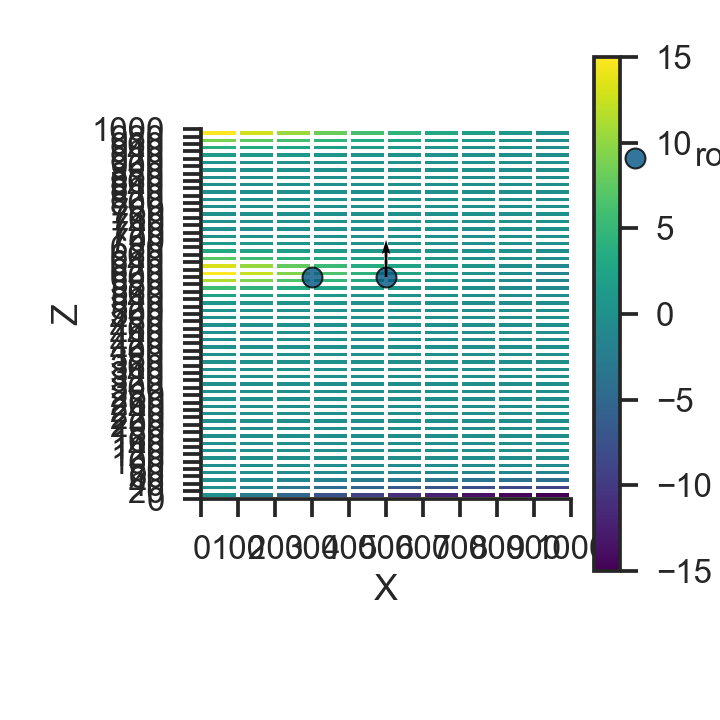

<IPython.core.display.Javascript object>


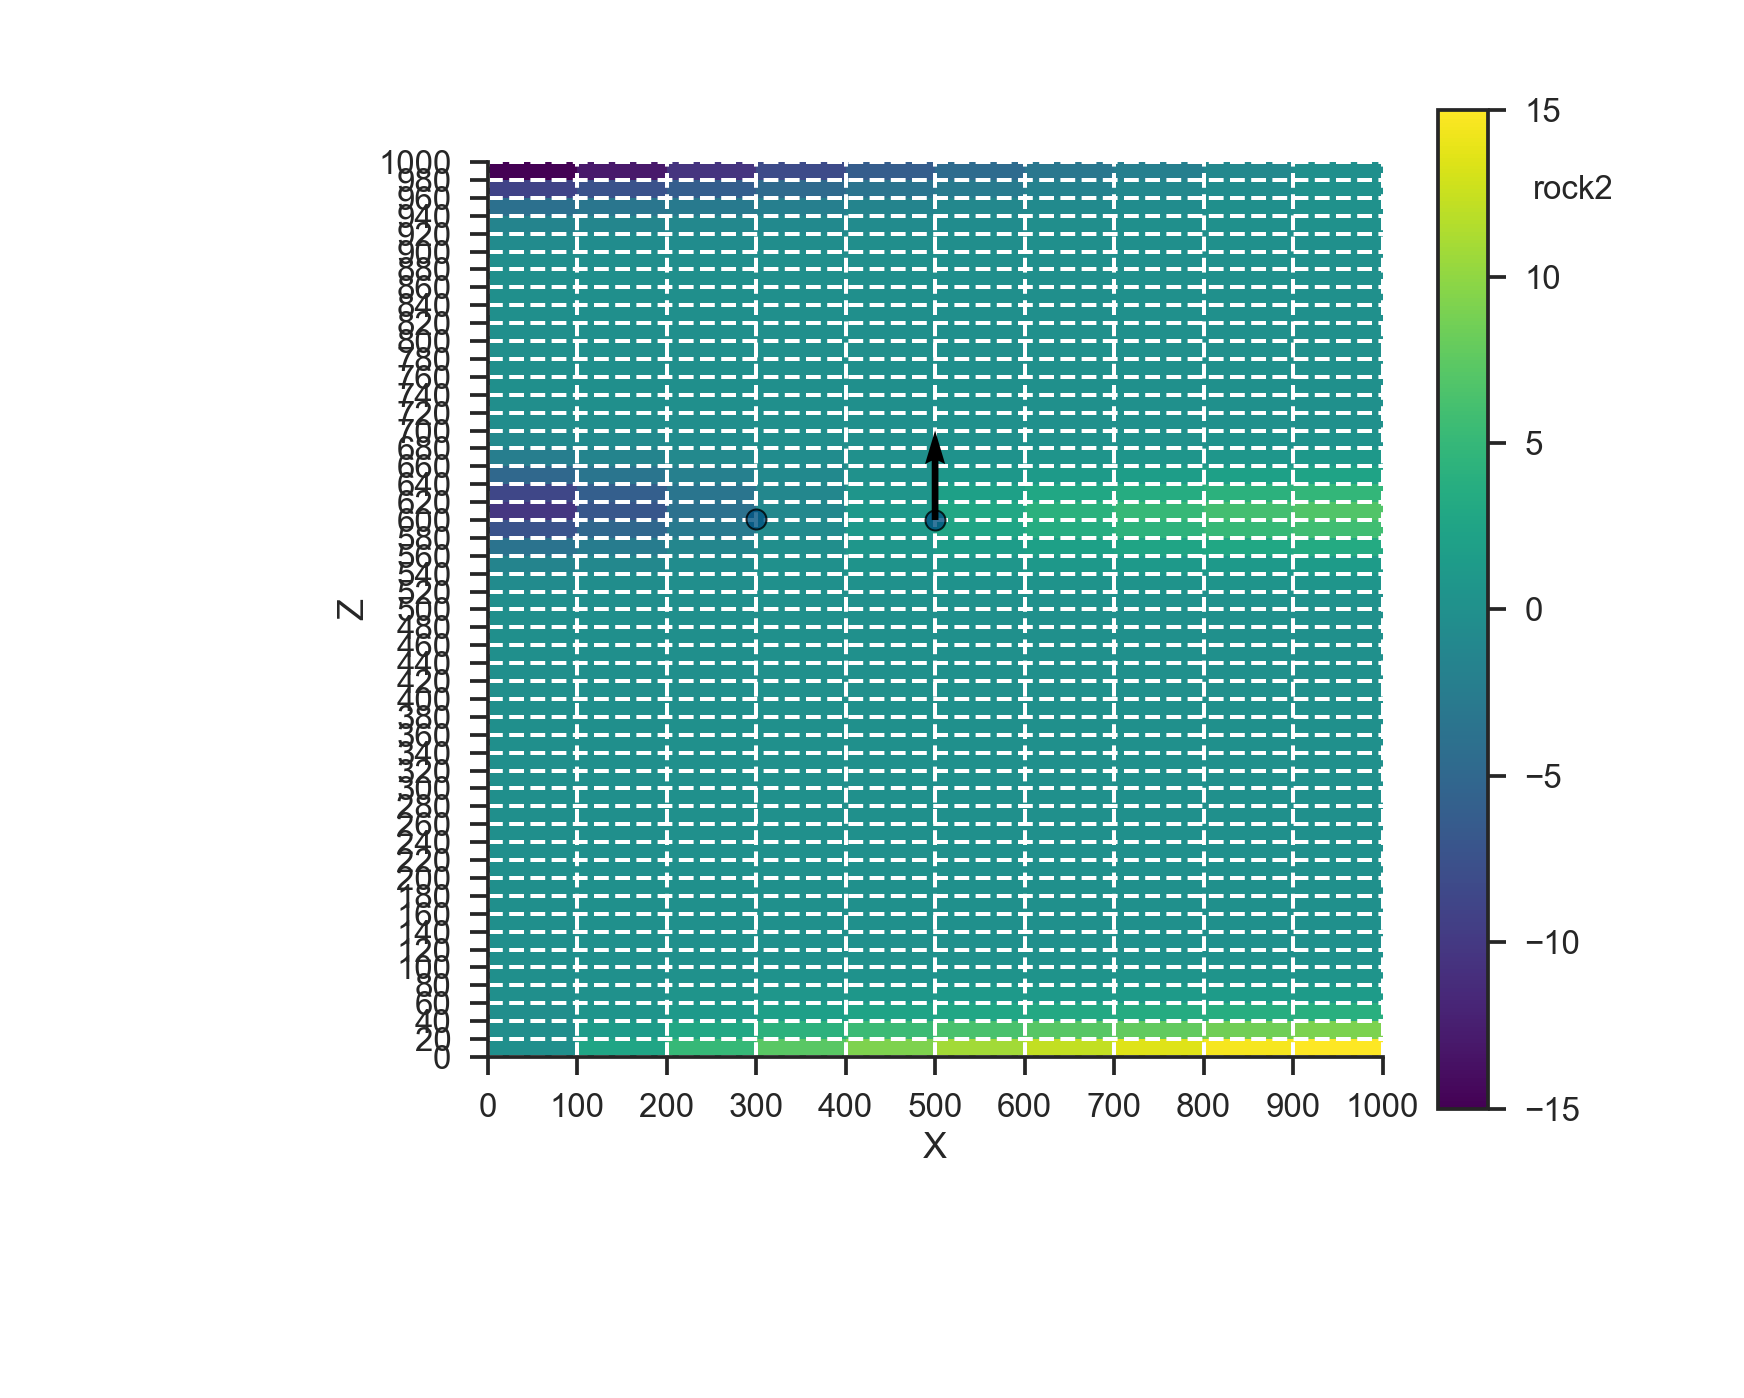

<IPython.core.display.Javascript object>


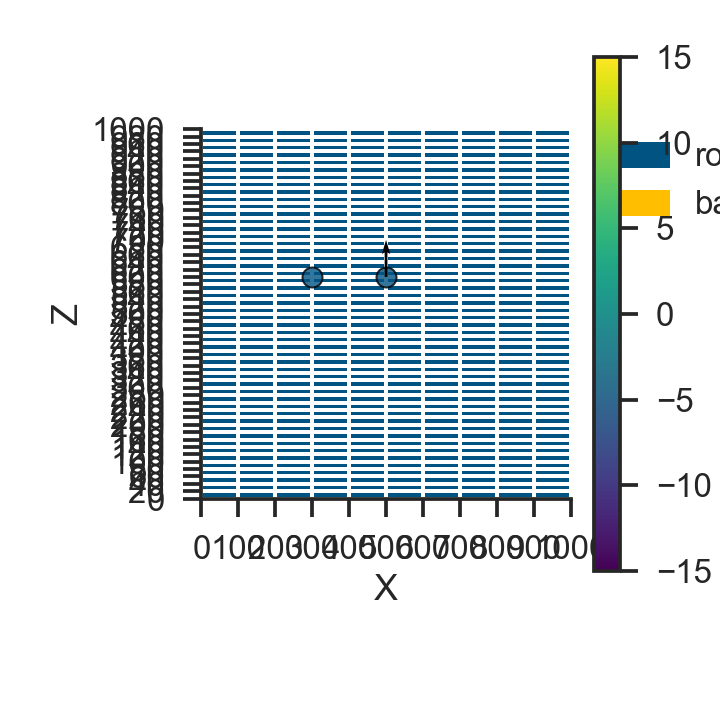

In [109]:
%matplotlib notebook
point = 0
v_max = 15 #jac[:500, 1, 2].max()
v_min = -15#jac[:500, 1, 2].min()

gp.plot.plot_data(geo_data)
plt.imshow(jac[:500, point, 2].reshape(geo_data.grid.regular_grid.resolution)[:, 0,:].T,
          origin='bottom', cmap='viridis', extent=(0,1000,0,1000),
            vmax= v_max, vmin = v_min)

ax = plt.gca();
ax.set_xticks(np.linspace(-0, 1000, 11));
ax.set_yticks(np.linspace(-0, 1000, 51));
ax.grid(color='w', linestyle='-', linewidth=2)
plt.colorbar()

point = 1

gp.plot.plot_data(geo_data)
plt.imshow(jac[:500, point, 2].reshape(geo_data.grid.regular_grid.resolution)[:, 0,:].T,
           origin='bottom', cmap='viridis', extent=(0,1000,0,1000),
           vmax=v_max , vmin= v_min)
plt.colorbar()
ax = plt.gca();
ax.set_xticks(np.linspace(-0, 1000, 11));
ax.set_yticks(np.linspace(-0, 1000, 51));
ax.grid(color='w', linestyle='--', linewidth=2)

gp.plot.plot_data(geo_data)
plt.imshow((jac[:500, 0, 2] + jac[:500, 1, 2]).reshape(geo_data.grid.regular_grid.resolution)[:, 0,:].T,
           origin='bottom', cmap='viridis', extent=(0,1000,0,1000),
           vmax=v_max , vmin= v_min)
plt.colorbar()
ax = plt.gca();
ax.set_xticks(np.linspace(-0, 1000, 11));
ax.set_yticks(np.linspace(-0, 1000, 51));
ax.grid(color='w', linestyle='-', linewidth=2)

### Differential derivative test:

In [164]:
geo_data.modify_surface_points(0, X = 400, Y= 500, Z=500, recompute_rescale_factor=True)

,X,Y,Z,X_r,Y_r,Z_r,surface,series,id,order_series,smooth
0,400.000,500.0,500,0.2501,0.5001,0.250102,rock2,Default series,1,1,1.000000e-08
1,500.001,500.0,600,0.7501,0.5001,0.750098,rock2,Default series,1,1,1.000000e-08


In [165]:
geo_data.surface_points.df['Z_r'] = 

,X,Y,Z,X_r,Y_r,Z_r,surface,series,id,order_series,smooth
0,400.000,500.0,500,0.2501,0.5001,0.250102,rock2,Default series,1,1,1.000000e-08
1,500.001,500.0,600,0.7501,0.5001,0.750098,rock2,Default series,1,1,1.000000e-08


In [189]:
arrays = np.array([])
for i in range(199):
    #geo_data.modify_surface_points(0, X = 400, Y= 500, Z=400+i, recompute_rescale_factor=True)
    geo_data.surface_points.df['Z_r'] = 0.250102 + .001*i - 0.01
    sol = gp.compute_model(geo_data)
    arrays = np.append(arrays, sol.lith_block)


n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.48020399999999996
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.48020399999999996
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.48220399999999997
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.48220399999999997
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.48420399999999997
drift[slice_init:slic

../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warning

n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.494204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.494204
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.496204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.496204
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.498204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2

../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warning

n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.508204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.508204
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.510204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.510204
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.512204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2

../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warning

n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.522204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.522204
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.524204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.524204
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.526204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2

../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warning

n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.538204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.538204
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.5402039999999999
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.5402039999999999
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.5422039999999999
drift[slice_init:slice_init+1][0] __str__ = [[

../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warning

n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.5542039999999999
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.5542039999999999
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.5562039999999999
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.5562039999999999
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.5582039999999999
drift[slice_init:slice_ini

../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warning

n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.5702039999999999
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.5702039999999999
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.5722039999999999
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.5722039999999999
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.5742039999999999
drift[slice_init:slice_ini

../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warning

n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.586204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.586204
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.588204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.588204
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.590204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2

../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warning

n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.604204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.604204
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.606204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.606204
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.608204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2

../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warning

n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.622204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.622204
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.624204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.624204
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.626204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2

../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warning

n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.638204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.638204
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.640204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.640204
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.642204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2

../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warning

n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.654204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.654204
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.656204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.656204
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.658204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2

../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warning

n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.670204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.670204
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.672204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.672204
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.674204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2

../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warning

n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.686204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.686204
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.688204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.688204
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.6902039999999999
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __s

../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warning

n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.7022039999999999
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.7022039999999999
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.7042039999999999
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.7042039999999999
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.7062039999999999
drift[slice_init:slice_ini

../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warning

n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.714204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.714204
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.716204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.716204
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.718204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2

../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warning

n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.730204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.730204
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.732204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.732204
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.734204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2

../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warning

n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.744204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.744204
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.746204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.746204
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.748204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2

../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warning

n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.7742039999999999
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.7742039999999999
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.7762039999999999
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.7762039999999999
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.7782039999999999
drift[slice_init:slice_ini

../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warning

n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.7902039999999999
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.7902039999999999
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.7922039999999999
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.7922039999999999
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.7942039999999999
drift[slice_init:slice_ini

../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warning

n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.8042039999999999
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.8042039999999999
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.8062039999999999
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.8062039999999999
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.8082039999999999
drift[slice_init:slice_ini

../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warning

n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.8202039999999999
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.8202039999999999
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.8222039999999999
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.8222039999999999
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.8242039999999999
drift[slice_init:slice_ini

../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warning

n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.836204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.836204
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.838204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.838204
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.840204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2

../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warning

n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.852204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.852204
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.854204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.854204
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.856204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2

../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warning

n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.866204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.866204
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.868204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.868204
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.089749100508997
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 5.090159100408997
n_surface_1 __str__ = [[1.]]
b __str__ = 0.870204
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2

../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))
../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))


In [190]:
gg = np.array([])
iter_a = arrays.reshape(-1, 10, 10)
ff = np.array([])
gg = np.array([])
for i in range(10):
    for j in range(10):
        gg = np.append(gg, iter_a[:, i, j][14])
        ff = np.append(ff, np.diff(iter_a[:, i, j])[100])

<IPython.core.display.Javascript object>


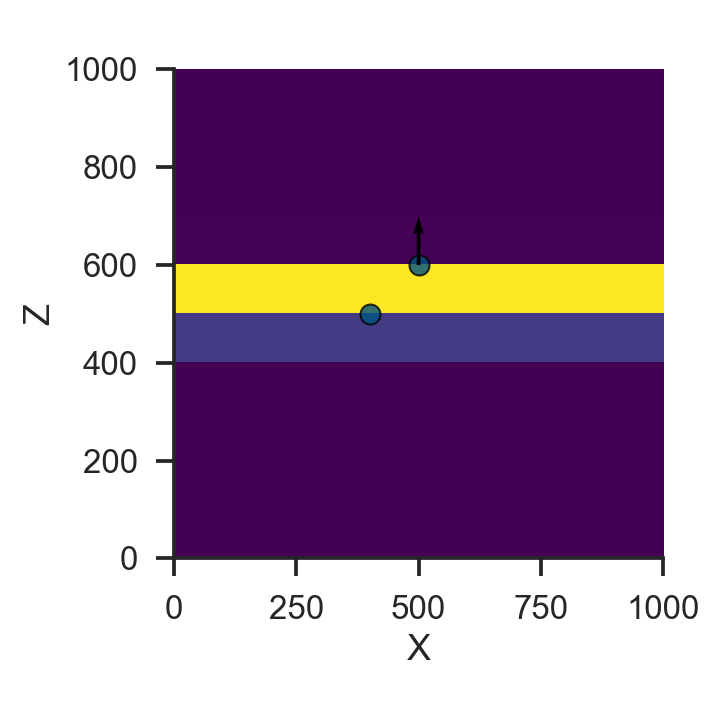

In [191]:
gp.plot.plot_section(geo_data, 0,
                         block=ff.reshape(geo_data.grid.regular_grid.resolution), show_data=True,
                         cmap='viridis',# show_grid=True,
                     norm=None
                        )

In [167]:
arrays = arrays.reshape(200, -1)

In [42]:
arrays[0].shape

(100,)

In [22]:
geo_data.surface_points

,X,Y,Z,X_r,Y_r,Z_r,surface,series,id,order_series,smooth
0,400.000,500.0,599,0.2501,0.5001,0.4976,rock2,Default series,1,1,1.000000e-08
1,500.001,500.0,600,0.7501,0.5001,0.5026,rock2,Default series,1,1,1.000000e-08


In [23]:
gp.compute_model(geo_data);

n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 4.613324984382699
n_surface_1 __str__ = [[1.]]
b __str__ = 0.9616706537273223
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.9616706537273223
n_surface_1 __str__ = [[-1.]]
b __str__ = -4.6317378547844585
drift[slice_init:slice_init+1][0] __str__ = [[2.]]


../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))


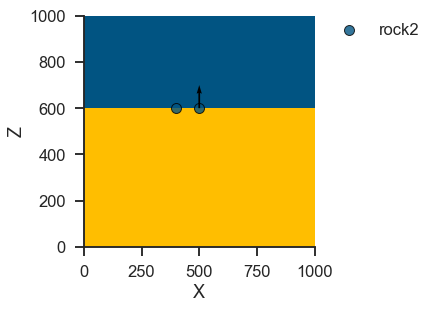

In [24]:
gp.plot.plot_section(geo_data, 0, show_data=True)

<IPython.core.display.Javascript object>


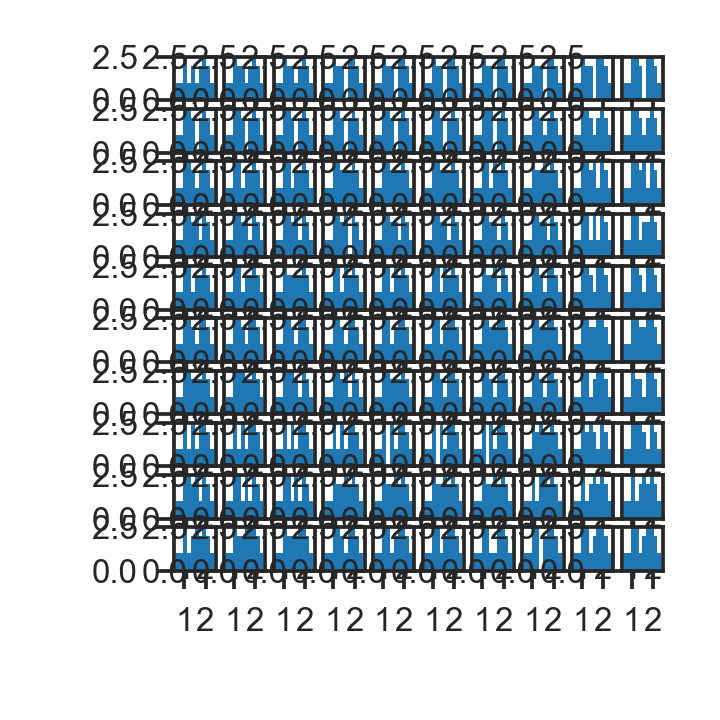

In [55]:
%matplotlib notebook
z_iter = 40

geo_data.modify_surface_points(0, X = 400, Y= 500, Z=400+z_iter, recompute_rescale_factor=True)
gp.plot.plot_data(geo_data)
plt.imshow(arrays[z_iter][:500].reshape(geo_data.grid.regular_grid.resolution)[:, 0,:].T,
          origin='bottom', cmap='viridis', extent=(0,1000,0,1000))

ax = plt.gca();
ax.set_xticks(np.linspace(-0, 1000, 11));
ax.set_yticks(np.linspace(-0, 1000, 11));
ax.grid(color='w', linestyle='-', linewidth=2) 

# The row below the blue dot is 1.94 for Index 0 Z = 600

In [69]:
k =arrays[0][:500].reshape(geo_data.grid.regular_grid.resolution)[:, 0,:].T
k

array([[1.00000007, 1.00000232, 1.00009464, 1.00411908, 1.14653805,
        1.85524087, 1.99370008, 2.00549946, 2.06593272, 2.37753693],
       [1.00000003, 1.00000117, 1.00005671, 1.00273252, 1.1025906 ,
        1.77958576, 1.98648404, 2.00101999, 2.01717758, 2.09504685],
       [1.00000001, 1.00000068, 1.00003837, 1.00194436, 1.0704991 ,
        1.65783939, 1.96632546, 1.99658435, 2.00243861, 2.0125055 ],
       [1.        , 1.00000035, 1.00002142, 1.00105708, 1.03381737,
        1.39716458, 1.86866069, 1.9741291 , 1.9931626 , 1.99837394],
       [0.99999998, 1.00000011, 1.00000669, 1.00028778, 1.00722265,
        1.08591761, 1.38157048, 1.69992165, 1.85971575, 1.93082875],
       [0.99999987, 1.00000001, 1.00000081, 1.00002655, 1.00046622,
        1.00400717, 1.01777774, 1.04816006, 1.0974756 , 1.17391797],
       [0.9999981 , 0.99999996, 1.00000003, 1.0000007 , 1.00000812,
        1.00004856, 1.00016698, 1.00040054, 1.00081404, 1.00163815],
       [0.99993257, 0.99999814, 0.9999999

In [74]:
iter_a = arrays.reshape(200, 10, 10)

In [84]:
arrays.T.shape

(100, 200)

In [86]:
arrays.T

array([[1.00000007, 1.00000007, 1.00000008, ..., 2.1701667 , 2.22699173,
        2.29652689],
       [1.00000003, 1.00000003, 1.00000003, ..., 2.00089998, 2.00123526,
        2.00169846],
       [1.00000001, 1.00000001, 1.00000001, ..., 2.00000394, 2.0000052 ,
        2.00000686],
       ...,
       [1.00000777, 1.00000816, 1.00000856, ..., 1.00030102, 1.000277  ,
        1.0002538 ],
       [1.00000003, 1.00000003, 1.00000003, ..., 0.99908552, 0.99875744,
        0.9983009 ],
       [0.99999972, 0.99999972, 0.99999972, ..., 0.82521032, 0.77009013,
        0.70227814]])

<IPython.core.display.Javascript object>


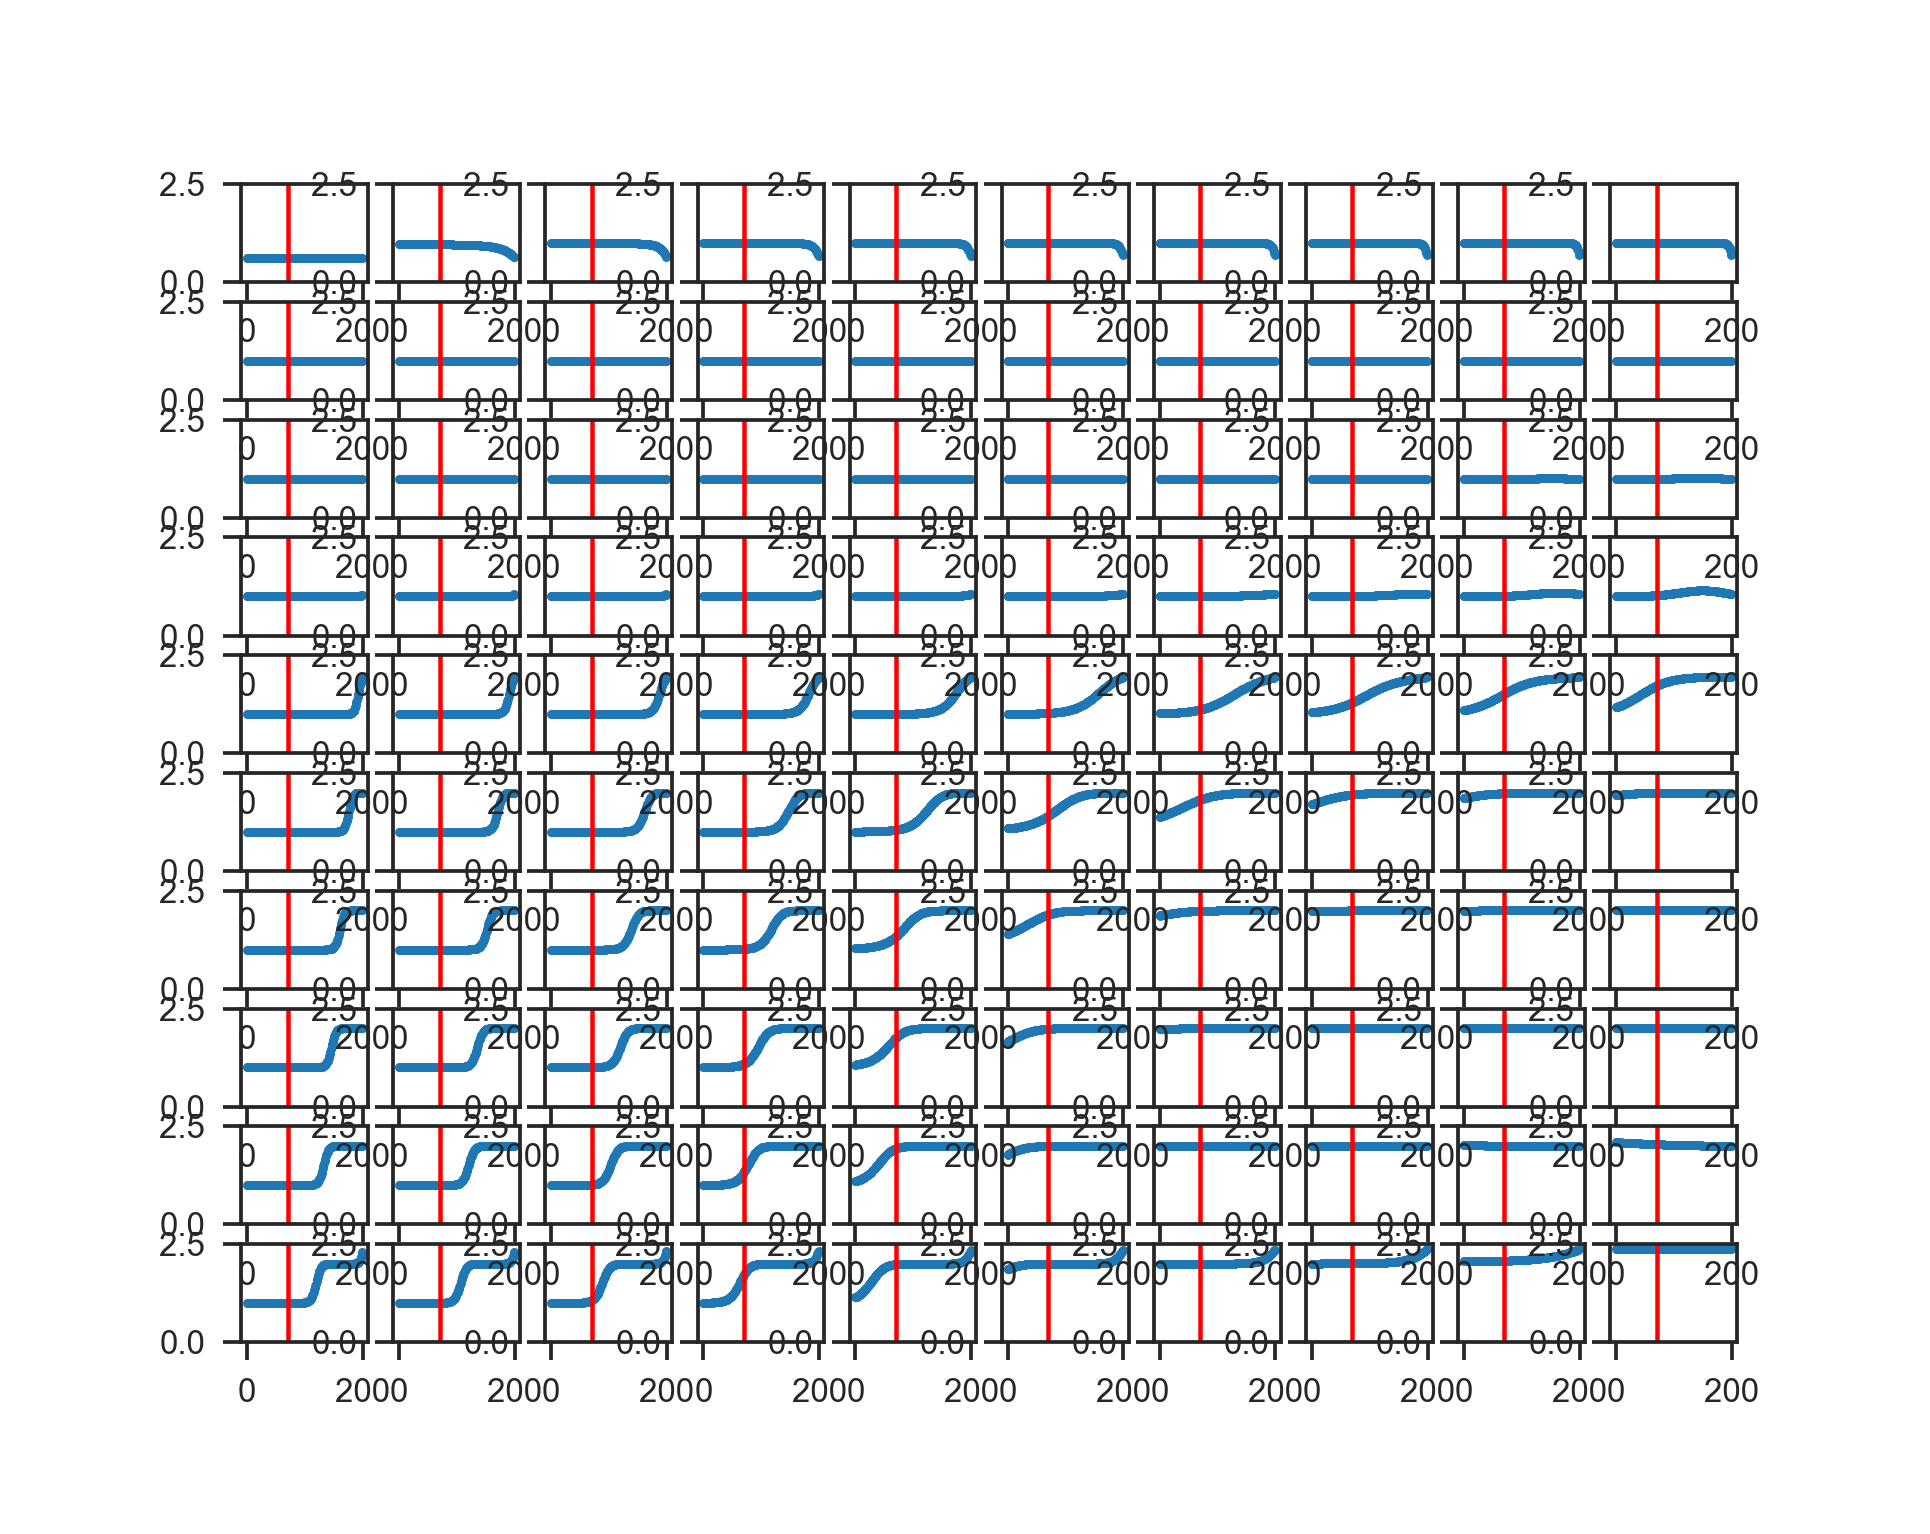

In [146]:
for i in range(10):
    for j in range(10):
       # print(i,j,  (1+i*10)-j+1)
        ax = plt.subplot(10,  10, (9-j)*10+i+1)#((1+j)*10)-i)
        ax.plot(iter_a[:, i, j], '.')
        ax.axvline(70, ymax=3, color='r')
        # ax.sharex()
        ax.set_ylim(0,2.5)


##### Jacobian

In [141]:
geo_data.modify_surface_points(0, X = 400, Y= 500, Z=470, recompute_rescale_factor=True)

,X,Y,Z,X_r,Y_r,Z_r,surface,series,id,order_series,smooth
0,400.000,500.0,470,0.30779,0.5001,0.2501,rock2,Default series,1,1,1.000000e-08
1,500.001,500.0,600,0.69241,0.5001,0.7501,rock2,Default series,1,1,1.000000e-08


In [142]:
jac = th_f_j(*geo_data.interpolator.get_python_input_block())

n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 2.4033346296760425
n_surface_1 __str__ = [[1.]]
b __str__ = -1.5857528521496411
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = -1.5857528521496411
n_surface_1 __str__ = [[-1.]]
b __str__ = -3.724038768183826
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 2.4033346296760425
n_surface_1 __str__ = [[1.]]
b __str__ = -1.5857528521496411
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = -1.5857528521496411
n_surface_1 __str__ = [[-1.]]
b __str__ = -3.724038768183826
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 2.4033346296760425
n_surface_1 __str__ = [[1.]]
b __str__ = -1.5857528521496411
drift[slice_init:s

n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 2.4033346296760425
n_surface_1 __str__ = [[1.]]
b __str__ = -1.5857528521496411
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = -1.5857528521496411
n_surface_1 __str__ = [[-1.]]
b __str__ = -3.724038768183826
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 2.4033346296760425
n_surface_1 __str__ = [[1.]]
b __str__ = -1.5857528521496411
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = -1.5857528521496411
n_surface_1 __str__ = [[-1.]]
b __str__ = -3.724038768183826
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [[2.]]
a __str__ = -1.5857528521496411
n_surface_1 __str__ = [[-1.]]
b __str__ = -3.724038768183826
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [

n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 2.4033346296760425
n_surface_1 __str__ = [[1.]]
b __str__ = -1.5857528521496411
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = -1.5857528521496411
n_surface_1 __str__ = [[-1.]]
b __str__ = -3.724038768183826
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 2.4033346296760425
n_surface_1 __str__ = [[1.]]
b __str__ = -1.5857528521496411
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = -1.5857528521496411
n_surface_1 __str__ = [[-1.]]
b __str__ = -3.724038768183826
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [[2.]]
a __str__ = -1.5857528521496411
n_surface_1 __str__ = [[-1.]]
b __str__ = -3.724038768183826
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [

n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 2.4033346296760425
n_surface_1 __str__ = [[1.]]
b __str__ = -1.5857528521496411
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = -1.5857528521496411
n_surface_1 __str__ = [[-1.]]
b __str__ = -3.724038768183826
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 2.4033346296760425
n_surface_1 __str__ = [[1.]]
b __str__ = -1.5857528521496411
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = -1.5857528521496411
n_surface_1 __str__ = [[-1.]]
b __str__ = -3.724038768183826
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [[2.]]
a __str__ = -1.5857528521496411
n_surface_1 __str__ = [[-1.]]
b __str__ = -3.724038768183826
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [

n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 2.4033346296760425
n_surface_1 __str__ = [[1.]]
b __str__ = -1.5857528521496411
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = -1.5857528521496411
n_surface_1 __str__ = [[-1.]]
b __str__ = -3.724038768183826
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [[2.]]
a __str__ = -1.5857528521496411
n_surface_1 __str__ = [[-1.]]
b __str__ = -3.724038768183826
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 2.4033346296760425
n_surface_1 __str__ = [[1.]]
b __str__ = -1.5857528521496411
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 2.4033346296760425
n_surface_1 __str__ = [[1.]]
b __str__ = -1.5857528521496411
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[

n_surface_1 __str__ = [[-1.]]
b __str__ = -3.724038768183826
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 2.4033346296760425
n_surface_1 __str__ = [[1.]]
b __str__ = -1.5857528521496411
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 2.4033346296760425
n_surface_1 __str__ = [[1.]]
b __str__ = -1.5857528521496411
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = -1.5857528521496411
n_surface_1 __str__ = [[-1.]]
b __str__ = -3.724038768183826
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 2.4033346296760425
n_surface_1 __str__ = [[1.]]
b __str__ = -1.5857528521496411
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = -1.5857528521496411
n_surface_1 __str__ = [[

b __str__ = -3.724038768183826
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 2.4033346296760425
n_surface_1 __str__ = [[1.]]
b __str__ = -1.5857528521496411
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = -1.5857528521496411
n_surface_1 __str__ = [[-1.]]
b __str__ = -3.724038768183826
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [[2.]]
a __str__ = -1.5857528521496411
n_surface_1 __str__ = [[-1.]]
b __str__ = -3.724038768183826
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 2.4033346296760425
n_surface_1 __str__ = [[1.]]
b __str__ = -1.5857528521496411
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 2.4033346296760425
n_surface_1 __str__ = [[1.]]
b __str__ = -1.5857528521

n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 2.4033346296760425
n_surface_1 __str__ = [[1.]]
b __str__ = -1.5857528521496411
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = -1.5857528521496411
n_surface_1 __str__ = [[-1.]]
b __str__ = -3.724038768183826
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [[2.]]
a __str__ = -1.5857528521496411
n_surface_1 __str__ = [[-1.]]
b __str__ = -3.724038768183826
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 2.4033346296760425
n_surface_1 __str__ = [[1.]]
b __str__ = -1.5857528521496411
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 2.4033346296760425
n_surface_1 __str__ = [[1.]]
b __str__ = -1.5857528521496411
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[

b __str__ = -1.5857528521496411
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = -1.5857528521496411
n_surface_1 __str__ = [[-1.]]
b __str__ = -3.724038768183826
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 2.4033346296760425
n_surface_1 __str__ = [[1.]]
b __str__ = -1.5857528521496411
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = -1.5857528521496411
n_surface_1 __str__ = [[-1.]]
b __str__ = -3.724038768183826
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [[2.]]
a __str__ = -1.5857528521496411
n_surface_1 __str__ = [[-1.]]
b __str__ = -3.724038768183826
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 2.4033346296760425
n_surface_1 __str__ = [[1.]]
b __str__ = -1.5857528521496411
drift[slice_init:slice_init+1][0] __str__ = [[1.

n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 2.4033346296760425
n_surface_1 __str__ = [[1.]]
b __str__ = -1.5857528521496411
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = -1.5857528521496411
n_surface_1 __str__ = [[-1.]]
b __str__ = -3.724038768183826
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_op_float_sigmoid __str__ = [[ 1.  1.  2. -1.]]
n_surface_0 __str__ = [[1.]]
a __str__ = 2.4033346296760425
n_surface_1 __str__ = [[1.]]
b __str__ = -1.5857528521496411
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = -1.5857528521496411
n_surface_1 __str__ = [[-1.]]
b __str__ = -3.724038768183826
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [[2.]]
a __str__ = -1.5857528521496411
n_surface_1 __str__ = [[-1.]]
b __str__ = -3.724038768183826
drift[slice_init:slice_init+1][0] __str__ = [[2.]]
n_surface_0 __str__ = [

<IPython.core.display.Javascript object>


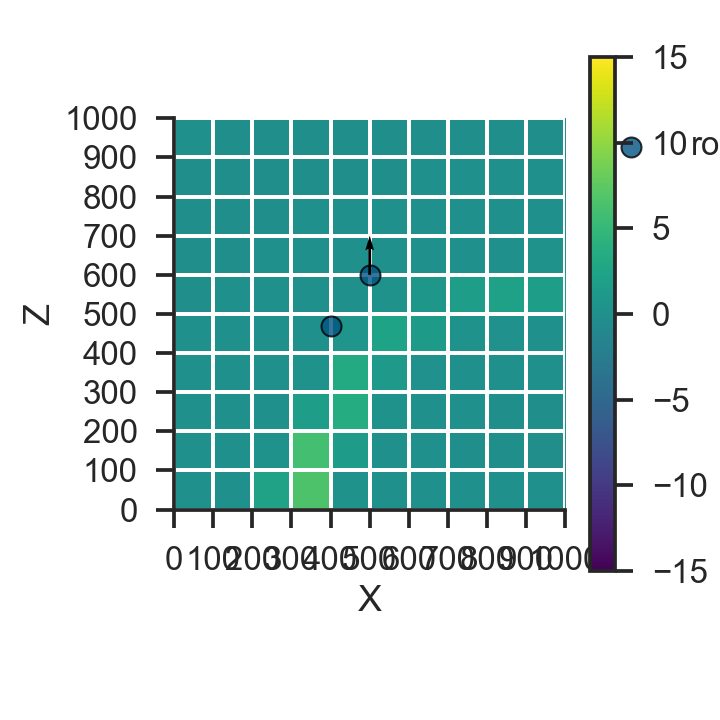

<IPython.core.display.Javascript object>


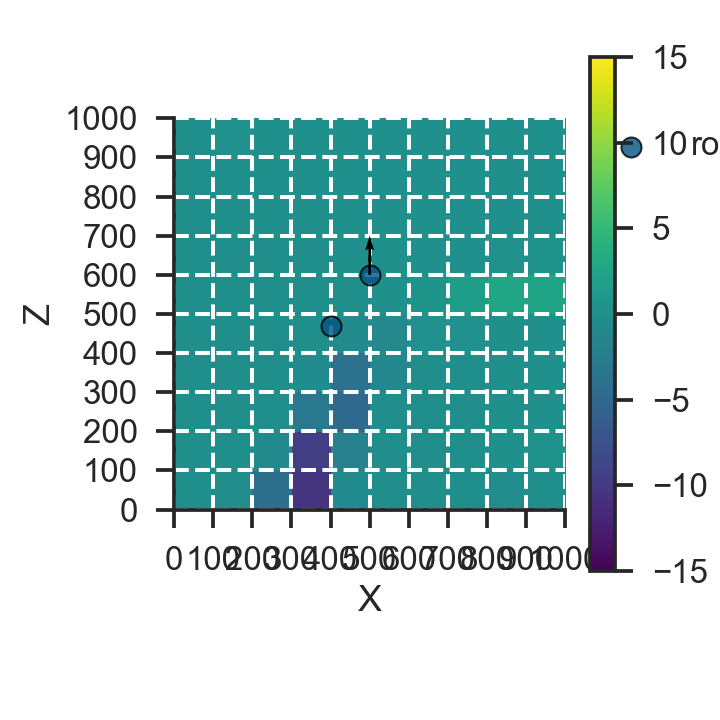

<IPython.core.display.Javascript object>


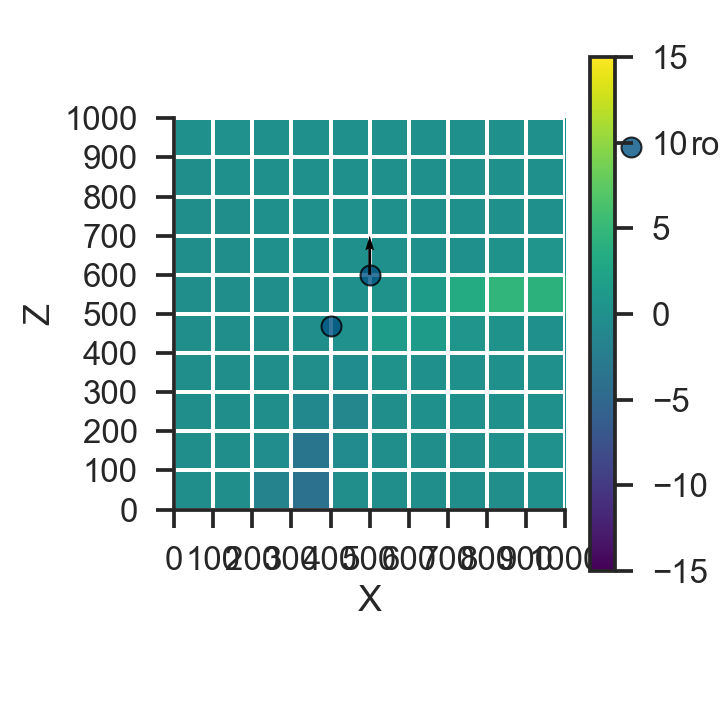

In [147]:
%matplotlib notebook
point = 0
v_max = 15 #jac[:500, 1, 2].max()
v_min = -15#jac[:500, 1, 2].min()

gp.plot.plot_data(geo_data)
plt.imshow(jac[:100, point, 2].reshape(geo_data.grid.regular_grid.resolution)[:, 0,:].T,
          origin='bottom', cmap='viridis', extent=(0,1000,0,1000),
            vmax= v_max, vmin = v_min)

ax = plt.gca();
ax.set_xticks(np.linspace(-0, 1000, 11));
ax.set_yticks(np.linspace(-0, 1000, 11));
ax.grid(color='w', linestyle='-', linewidth=2)
plt.colorbar()

point = 1

gp.plot.plot_data(geo_data)
plt.imshow(jac[:100, point, 2].reshape(geo_data.grid.regular_grid.resolution)[:, 0,:].T,
           origin='bottom', cmap='viridis', extent=(0,1000,0,1000),
           vmax=v_max , vmin= v_min)
plt.colorbar()
ax = plt.gca();
ax.set_xticks(np.linspace(-0, 1000, 11));
ax.set_yticks(np.linspace(-0, 1000, 11));
ax.grid(color='w', linestyle='--', linewidth=2)

gp.plot.plot_data(geo_data)
plt.imshow((jac[:100, 0, 2] + jac[:100, 1, 2]).reshape(geo_data.grid.regular_grid.resolution)[:, 0,:].T,
           origin='bottom', cmap='viridis', extent=(0,1000,0,1000),
           vmax=v_max , vmin= v_min)
plt.colorbar()
ax = plt.gca();
ax.set_xticks(np.linspace(-0, 1000, 11));
ax.set_yticks(np.linspace(-0, 1000, 11));
ax.grid(color='w', linestyle='-', linewidth=2)

----------